In [1]:
from cliff_game import CliffGame, Action
from algorithms import Sarsa

In [2]:
cg = CliffGame()
print(cg)

reward = 0



|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
|     |     |     |     |     |     |     |     |     |     |     |     |
|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
|     |     |     |     |     |     |     |     |     |     |     |     |
|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
|     |     |     |     |     |     |     |     |     |     |     |     |
|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
|  S* |  C  |  C  |  C  |  C  |  C  |  C  |  C  |  C  |  C  |  C  |  G  |
|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|



In [3]:
r, game_over = cg.move(Action.UP)
reward += r
print(reward, game_over)
print(cg)

-1 False

|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
|     |     |     |     |     |     |     |     |     |     |     |     |
|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
|     |     |     |     |     |     |     |     |     |     |     |     |
|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
|   * |     |     |     |     |     |     |     |     |     |     |     |
|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
|  S  |  C  |  C  |  C  |  C  |  C  |  C  |  C  |  C  |  C  |  C  |  G  |
|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|



In [4]:
seq = [Action.RIGHT, Action.RIGHT, Action.DOWN, Action.RIGHT]

for i, action in enumerate(seq):
    print(f"{i+1}/{len(seq)} Moving {action.name}")
    r, game_over = cg.move(action)
    reward += r
    if game_over:
        print("Game Over")
        break

print("\nTotal reward:", reward)
print(cg)

1/4 Moving RIGHT
2/4 Moving RIGHT
3/4 Moving DOWN
Game Over

Total reward: -103

|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
|     |     |     |     |     |     |     |     |     |     |     |     |
|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
|     |     |     |     |     |     |     |     |     |     |     |     |
|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
|     |     |     |     |     |     |     |     |     |     |     |     |
|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
|  S  |  C  |  C* |  C  |  C  |  C  |  C  |  C  |  C  |  C  |  C  |  G  |
|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|



In [19]:
sarsa = Sarsa(cg)
rewards = []
for i in range(500):
    cg.reset()
    _, _, r = sarsa.run()
    rewards.append(r)
    # print(" ", r)

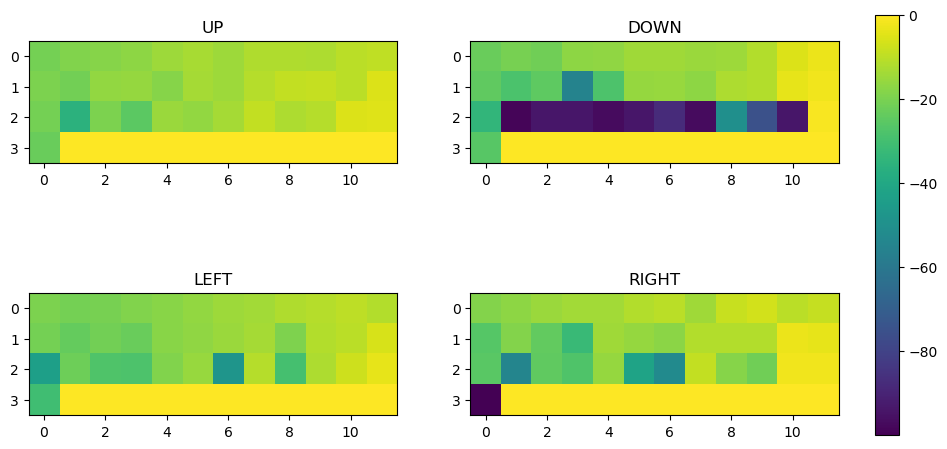

In [20]:
sarsa.plot_q_values()


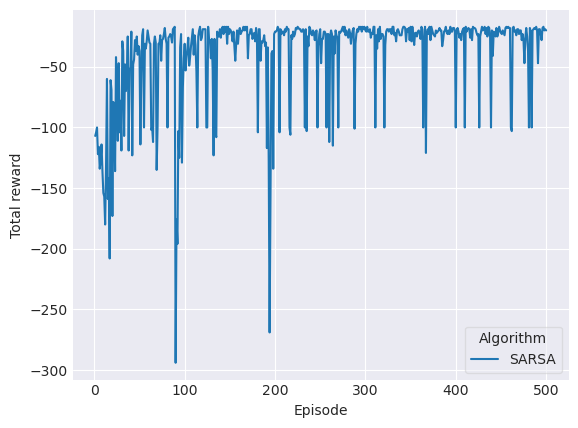

In [21]:
import matplotlib.pyplot as plt
import numpy as np

with plt.style.context('seaborn-v0_8-darkgrid'):
    fig, ax  = plt.subplots()
    ax.plot(np.arange(len(rewards)) + 1, rewards, label="SARSA")
    ax.set_xlabel("Episode")
    ax.set_ylabel("Total reward")

    ax.legend(title="Algorithm", fancybox=True, framealpha=0.5, frameon=True)

In [22]:

policy_idx = np.argmax(sarsa.q_values, axis=-1)
policy_actions = np.array(sarsa.actions)[policy_idx]

terminal = ~np.any(sarsa.q_values, axis=-1)

policy_actions[terminal] = ""
policy_actions

array([[<Action.RIGHT: 4>, <Action.RIGHT: 4>, <Action.RIGHT: 4>,
        <Action.RIGHT: 4>, <Action.RIGHT: 4>, <Action.RIGHT: 4>,
        <Action.RIGHT: 4>, <Action.UP: 1>, <Action.RIGHT: 4>,
        <Action.RIGHT: 4>, <Action.DOWN: 2>, <Action.DOWN: 2>],
       [<Action.UP: 1>, <Action.RIGHT: 4>, <Action.UP: 1>,
        <Action.UP: 1>, <Action.RIGHT: 4>, <Action.UP: 1>,
        <Action.UP: 1>, <Action.UP: 1>, <Action.UP: 1>, <Action.UP: 1>,
        <Action.RIGHT: 4>, <Action.DOWN: 2>],
       [<Action.UP: 1>, <Action.LEFT: 3>, <Action.UP: 1>, <Action.UP: 1>,
        <Action.UP: 1>, <Action.LEFT: 3>, <Action.UP: 1>,
        <Action.RIGHT: 4>, <Action.UP: 1>, <Action.UP: 1>,
        <Action.RIGHT: 4>, <Action.DOWN: 2>],
       [<Action.UP: 1>, '', '', '', '', '', '', '', '', '', '', '']],
      dtype=object)

In [23]:
sarsa.actions

[<Action.UP: 1>, <Action.DOWN: 2>, <Action.LEFT: 3>, <Action.RIGHT: 4>]

In [24]:
cg.reset()
trajectory, _, _ = sarsa.run(dry=True)
trajectory

[State(x=3, y=0),
 State(x=2, y=0),
 State(x=2, y=0),
 State(x=1, y=0),
 State(x=0, y=0),
 State(x=0, y=0),
 State(x=0, y=1),
 State(x=0, y=2),
 State(x=0, y=3),
 State(x=0, y=4),
 State(x=0, y=5),
 State(x=0, y=6),
 State(x=0, y=7),
 State(x=0, y=7),
 State(x=0, y=7),
 State(x=0, y=7),
 State(x=0, y=7),
 State(x=0, y=7),
 State(x=0, y=7),
 State(x=0, y=7),
 State(x=0, y=7),
 State(x=0, y=7),
 State(x=0, y=7),
 State(x=0, y=7),
 State(x=0, y=6),
 State(x=0, y=7),
 State(x=0, y=7),
 State(x=0, y=7),
 State(x=1, y=7),
 State(x=0, y=7),
 State(x=0, y=7),
 State(x=0, y=7),
 State(x=0, y=7),
 State(x=0, y=7),
 State(x=0, y=7),
 State(x=0, y=7),
 State(x=0, y=7),
 State(x=0, y=7),
 State(x=0, y=7),
 State(x=1, y=7),
 State(x=1, y=6),
 State(x=0, y=6),
 State(x=0, y=7),
 State(x=0, y=8),
 State(x=0, y=9),
 State(x=0, y=10),
 State(x=1, y=10),
 State(x=1, y=11),
 State(x=2, y=11),
 State(x=3, y=11)]

In [25]:
y_coords, x_coords = list(zip(*trajectory))


Text(0.5, 0.98, 'SARSA results')

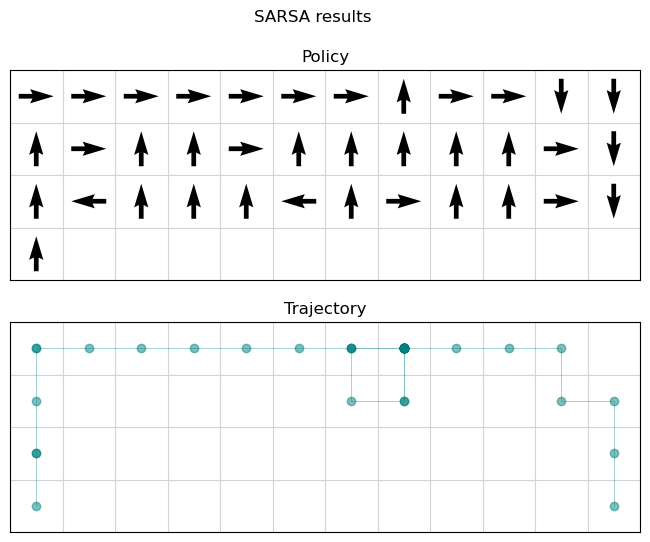

In [26]:
x_components = np.array([0, 0, -1, 1]).astype(float)
y_components = np.array([1, -1, 0, 0]).astype(float)

u = x_components[policy_idx]
v = y_components[policy_idx]

u[terminal] = np.nan
v[terminal] = np.nan


fig, axes = plt.subplots(2, 1, sharex='all', sharey='all', figsize=(10, 6))


for ax in axes:
    ax.yaxis.set_inverted(True)
    ax.set_aspect('equal')
    ax.grid(color='lightgrey')
    ax.set_xticks(np.arange(policy_idx.shape[1]+1)-0.5)
    ax.set_yticks(np.arange(policy_idx.shape[0])-0.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlim(-0.5, policy_idx.shape[1]-0.5)
    ax.set_ylim(policy_idx.shape[0]-0.5, -0.5)
    ax.tick_params(axis='both', which='major', length=0)

axes[0].quiver(u, v, pivot='mid')
axes[0].set_title("Policy")

axes[1].plot(x_coords, y_coords, marker='o', lw=0.5, color='teal', alpha=0.5)
axes[1].set_title("Trajectory")

fig.suptitle("SARSA results")
